# Meta Prompting: A Guide to Automated Prompt Optimization

Welcome to our cookbook on meta prompting! In this guide, we'll explore how to take a basic prompt and refine it to enhance the quality of outputs from a language model. We'll use the example of summarizing news reports to illustrate the process.


Meta prompting is all about iteratively refining prompts to get more accurate and detailed responses from a language model. We know that prompt engineering can be a challenging and time-consuming task that often requires technical expertise. But with meta prompting, you can have a virtual prompt engineer by your side! By leveraging the capabilities of `o1-preview`, a more intelligent model with advanced reasoning skills, anyone can improve their prompts without needing deep technical knowledge.

We're committed to making your development journey with LLMs smoother and more accessible through this technique. Don't forget to check out our [Generate Anything](https://platform.openai.com/docs/guides/prompt-generation) feature in the playground — it's a fantastic starting point to dive into meta prompting.

In this example, we'll begin with a simple prompt for summarizing news articles and then enhance it to see how the outputs improve. We'll use `o1-preview` to analyze and refine our prompt, adding more detail and clarity along the way. Finally, we'll evaluate the outputs systematically to understand the impact of our refinements.

In [1]:
import pandas as pd
import openai 
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from pydantic import BaseModel
from datasets import load_dataset

client = openai.Client()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing the Data

Let's kick things off by importing the `bbc_news_alltime` dataset from [HuggingFace](https://huggingface.co/datasets/RealTimeData/bbc_news_alltime). This dataset contains all BBC News articles, capturing everything published monthly from 2017 up to the latest complete month. For our experiment, we'll focus exclusively on the most recent month—September 2024—to keep things current and manageable.


In [2]:
ds = load_dataset("RealTimeData/bbc_news_alltime", "2024-09")
df = pd.DataFrame(ds['train'])
df.head()

,title,published_date,authors,description,section,content,link,top_image
0,Americast - Profile: Who is Donald Trump? (Par...,2024-09-01,None,How the man became The Donald,None,Americanswers! Do Harris/Trump actually need A...,http://www.bbc.co.uk/sounds/play/p0jmwg24,https://ichef.bbci.co.uk/images/ic/320x320/p0j...
1,Newscast - Keir Diary… A Week in the Life of t...,2024-09-01,None,Recapping a busy week for Sir Keir Starmer.,None,"The Riots, The Police and Social Media\n\nAdam...",http://www.bbc.co.uk/sounds/play/m0022js5,https://ichef.bbci.co.uk/images/ic/320x320/p0j...
2,Americast - The Harris VS Trump Debate... and ...,2024-09-11,None,"And why is ""THEY'RE EATING THE DOGS"" trending ...",None,The Harris VS Trump Debate... and a Taylor Swi...,http://www.bbc.co.uk/sounds/play/p0jpskr7,https://ichef.bbci.co.uk/images/ic/320x320/p0j...
3,Americast - The Harris VS Trump Debate... and ...,2024-09-12,None,"And why is ""THEY'RE EATING THE DOGS"" trending ...",None,The Harris VS Trump Debate... and a Taylor Swi...,http://www.bbc.co.uk/sounds/play/p0jpskr7,https://ichef.bbci.co.uk/images/ic/320x320/p0j...
4,Quiz of the week: Who blew out the Paralympic ...,2024-09-12,https://www.facebook.com/bbcnews,Test how closely you've been paying attention ...,World,It's the weekly news quiz - how closely have y...,http://www.bbc.co.uk/news/world-69340211,https://ichef.bbci.co.uk/news/1024/branded_new...


## Iterating on Prompts


Let's start with a straightforward prompt and then use `o1-preview` to enhance it for better results. We want to summarize news articles, so this is what i'll ask the model to do. 

In [3]:
simple_prompt = "Summarize this news article: {article}"


To improve the prompt, we need to provide `o1-preview` with the context and goals we want to achieve. We can then ask it to generate a more detailed prompt that would produce richer and more comprehensive news summaries.

In [4]:
meta_prompt = """
Improve the following prompt to generate a more detailed summary. 
Adhere to prompt engineering best practices. 
Make sure the structure is clear and intuitive and contains the type of news, tags and sentiment analysis.

{simple_prompt}

Only return the prompt.
"""

In [5]:
def get_model_response(messages, model="o1-preview"):
    response = client.chat.completions.create(
        messages=messages,
        model=model,
    )
    return response.choices[0].message.content


complex_prompt = get_model_response([{"role": "user", "content": meta_prompt.format(simple_prompt=simple_prompt)}])
complex_prompt

'Please read the following news article and produce a detailed summary with the following structure:\n\n1. **Type of News**: Identify the category or domain of the news article (e.g., Politics, Technology, Sports, etc.).\n\n2. **Summary**: Provide a comprehensive and detailed summary of the article, highlighting the main points and key details.\n\n3. **Tags**: List relevant keywords or tags associated with the content of the article.\n\n4. **Sentiment Analysis**: Determine the overall sentiment of the article (Positive, Negative, Neutral) and provide a brief explanation for your assessment.\n\nHere is the article:\n\n{article}'

## Generating the Summaries

Now that we have both prompts, let's generate the summaries! For each entry in our dataset, we'll use both the simple and the enhanced prompts to see how they compare. By doing this, we'll get a firsthand look at how our refinements with `o1-preview` can lead to richer and more detailed summaries. Let's dive in and see the difference for ourselves!

In [6]:
def generate_resonse(prompt): 
    messages = [{"role": "user", "content": prompt}]
    response = get_model_response(messages, model="gpt-4o-mini")
    return response

def generate_summaries(row):
    simple_itinerary = generate_resonse(simple_prompt.format(article=row["content"]))
    complex_itinerary = generate_resonse(complex_prompt + row["content"])
    return simple_itinerary, complex_itinerary

Let's check if everything looks good and if we can generate a summary for the first news report. 

In [7]:
generate_summaries(df.iloc[0])

('The article discusses the ongoing debates surrounding the necessity of extensive policy agendas for political candidates like Kamala Harris and Donald Trump in the lead-up to the election. It explores whether voters prioritize well-defined policies or if charisma, personality, and other factors play a more significant role in their decision-making process. Expert opinions and voter sentiments are examined, revealing insights into how much impact concrete policies have compared to broader campaign themes and messages. The article emphasizes the complexities of voter preferences and the evolving nature of political campaigns in contemporary America.',
 '1. **Type of News**: Politics\n\n2. **Summary**: The article titled “Americanswers! Do Harris/Trump actually need ANY policies?” addresses the significant issues in the lead-up to the upcoming election, specifically focusing on the political strategies of two prominent figures: Kamala Harris and Donald Trump. It engages with the questio

By comparing the summaries generated from the simple and enhanced prompts, we can already see significant improvements. The initial summary gives us a general overview of the article, whereas the enhanced summary dives deeper — it not only provides a detailed summary but also categorizes the news type, lists relevant tags, and even includes a sentiment analysis.

Let's test on the entire dataset now! 

In [8]:
# Add new columns to the dataframe for storing itineraries
df['simple_summary'] = None
df['complex_summary'] = None

# Use ThreadPoolExecutor to generate itineraries concurrently
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(generate_summaries, row): index for index, row in df.iterrows()}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Generating Itineraries"):
        index = futures[future]
        simple_itinerary, complex_itinerary = future.result()
        df.at[index, 'simple_summary'] = simple_itinerary
        df.at[index, 'complex_summary'] = complex_itinerary

df.head()

Generating Itineraries: 100%|██████████| 59/59 [00:26<00:00,  2.24it/s]


,title,published_date,authors,description,section,content,link,top_image,simple_summary,complex_summary
0,Americast - Profile: Who is Donald Trump? (Par...,2024-09-01,None,How the man became The Donald,None,Americanswers! Do Harris/Trump actually need A...,http://www.bbc.co.uk/sounds/play/p0jmwg24,https://ichef.bbci.co.uk/images/ic/320x320/p0j...,"The article titled ""Americanswers! Do Harris/T...",1. **Type of News**: Politics\n\n2. **Summary*...
1,Newscast - Keir Diary… A Week in the Life of t...,2024-09-01,None,Recapping a busy week for Sir Keir Starmer.,None,"The Riots, The Police and Social Media\n\nAdam...",http://www.bbc.co.uk/sounds/play/m0022js5,https://ichef.bbci.co.uk/images/ic/320x320/p0j...,"In the article ""The Riots, The Police and Soci...",1. **Type of News**: Politics / Social Issues\...
2,Americast - The Harris VS Trump Debate... and ...,2024-09-11,None,"And why is ""THEY'RE EATING THE DOGS"" trending ...",None,The Harris VS Trump Debate... and a Taylor Swi...,http://www.bbc.co.uk/sounds/play/p0jpskr7,https://ichef.bbci.co.uk/images/ic/320x320/p0j...,The article discusses a debate between Vice Pr...,1. **Type of News**: Politics / Entertainment\...
3,Americast - The Harris VS Trump Debate... and ...,2024-09-12,None,"And why is ""THEY'RE EATING THE DOGS"" trending ...",None,The Harris VS Trump Debate... and a Taylor Swi...,http://www.bbc.co.uk/sounds/play/p0jpskr7,https://ichef.bbci.co.uk/images/ic/320x320/p0j...,"In a recent debate, Vice President Kamala Harr...",1. **Type of News**: Politics/Entertainment\n\...
4,Quiz of the week: Who blew out the Paralympic ...,2024-09-12,https://www.facebook.com/bbcnews,Test how closely you've been paying attention ...,World,It's the weekly news quiz - how closely have y...,http://www.bbc.co.uk/news/world-69340211,https://ichef.bbci.co.uk/news/1024/branded_new...,The article introduces a weekly news quiz desi...,1. **Type of News**: General News / Media / En...


## Evaluating the Results

To assess the difference in performance between the two prompts, we'll use a structured evaluation approach with the LLM acting as a judge. This means we'll leverage the language model itself to evaluate and compare the outputs based on specific criteria.

**What Does "LLM as a Judge" Mean?**

Using an LLM as a judge involves having the language model evaluate its own outputs or those of another model. It applies predefined criteria to assess aspects like accuracy, clarity, and relevance. This approach helps us obtain an objective and consistent evaluation without human bias, making it easier to identify improvements between different prompts. Our cookbook on [Getting Started with OpenAI Evals](https://cookbook.openai.com/examples/evaluation/getting_started_with_openai_evals) offers a glimps on how you can get started with this approach.


Here's the prompt we'll use for evaluation:

In [9]:
evaluation_prompt = """
You are an expert editor tasked with evaluating the quality of a news article summary. Below is the original article and the summary to be evaluated:

**Original Article**:  
{original_article}

**Summary**:  
{summary}

Please evaluate the summary based on the following criteria, using a scale of 1 to 5 (1 being the lowest and 5 being the highest). Be critical in your evaluation and only give high scores for exceptional summaries:

1. **Categorization and Context**: Does the summary clearly identify the type or category of news (e.g., Politics, Technology, Sports) and provide appropriate context?  
2. **Keyword and Tag Extraction**: Does the summary include relevant keywords or tags that accurately capture the main topics and themes of the article?  
3. **Sentiment Analysis**: Does the summary accurately identify the overall sentiment of the article and provide a clear, well-supported explanation for this sentiment?  
4. **Clarity and Structure**: Is the summary clear, well-organized, and structured in a way that makes it easy to understand the main points?  
5. **Detail and Completeness**: Does the summary provide a detailed account that includes all necessary components (type of news, tags, sentiment) comprehensively?  


Provide your scores and justifications for each criterion, ensuring a rigorous and detailed evaluation.
"""

class ScoreCard(BaseModel):
    categorization: int
    keyword_extraction: int
    sentiment_analysis: int
    clarity_structure: int
    detail_completeness: int
    justification: str

Here's a pro tip — you can actually use meta prompting to refine your evaluation prompt as well! By applying the same iterative enhancement to the prompt that instructs the LLM to act as a judge, you can make your evaluations even more precise and insightful. 

Let's use this prompt to evaluate our summaries!

In [10]:
def evaluate_summaries(row):
    simple_messages = [{"role": "user", "content": evaluation_prompt.format(original_article=row["content"], summary=row['simple_summary'])}]
    complex_messages = [{"role": "user", "content": evaluation_prompt.format(original_article=row["content"], summary=row['complex_summary'])}]
    
    simple_summary = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=simple_messages,
        response_format=ScoreCard)
    simple_summary = simple_summary.choices[0].message.parsed
    
    complex_summary = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=complex_messages,
        response_format=ScoreCard)
    complex_summary = complex_summary.choices[0].message.parsed
    
    return simple_summary, complex_summary

# Add new columns to the dataframe for storing evaluations
df['simple_evaluation'] = None
df['complex_evaluation'] = None

# Use ThreadPoolExecutor to evaluate itineraries concurrently
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(evaluate_summaries, row): index for index, row in df.iterrows()}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Evaluating Summaries"):
        index = futures[future]
        simple_evaluation, complex_evaluation = future.result()
        df.at[index, 'simple_evaluation'] = simple_evaluation
        df.at[index, 'complex_evaluation'] = complex_evaluation

df.head()

Evaluating Summaries: 100%|██████████| 59/59 [00:46<00:00,  1.27it/s]


,title,published_date,authors,description,section,content,link,top_image,simple_summary,complex_summary,simple_evaluation,complex_evaluation
0,Americast - Profile: Who is Donald Trump? (Par...,2024-09-01,None,How the man became The Donald,None,Americanswers! Do Harris/Trump actually need A...,http://www.bbc.co.uk/sounds/play/p0jmwg24,https://ichef.bbci.co.uk/images/ic/320x320/p0j...,"The article titled ""Americanswers! Do Harris/T...",1. **Type of News**: Politics\n\n2. **Summary*...,categorization=4 keyword_extraction=3 sentimen...,categorization=5 keyword_extraction=5 sentimen...
1,Newscast - Keir Diary… A Week in the Life of t...,2024-09-01,None,Recapping a busy week for Sir Keir Starmer.,None,"The Riots, The Police and Social Media\n\nAdam...",http://www.bbc.co.uk/sounds/play/m0022js5,https://ichef.bbci.co.uk/images/ic/320x320/p0j...,"In the article ""The Riots, The Police and Soci...",1. **Type of News**: Politics / Social Issues\...,categorization=4 keyword_extraction=5 sentimen...,categorization=5 keyword_extraction=5 sentimen...
2,Americast - The Harris VS Trump Debate... and ...,2024-09-11,None,"And why is ""THEY'RE EATING THE DOGS"" trending ...",None,The Harris VS Trump Debate... and a Taylor Swi...,http://www.bbc.co.uk/sounds/play/p0jpskr7,https://ichef.bbci.co.uk/images/ic/320x320/p0j...,The article discusses a debate between Vice Pr...,1. **Type of News**: Politics / Entertainment\...,categorization=5 keyword_extraction=4 sentimen...,categorization=5 keyword_extraction=5 sentimen...
3,Americast - The Harris VS Trump Debate... and ...,2024-09-12,None,"And why is ""THEY'RE EATING THE DOGS"" trending ...",None,The Harris VS Trump Debate... and a Taylor Swi...,http://www.bbc.co.uk/sounds/play/p0jpskr7,https://ichef.bbci.co.uk/images/ic/320x320/p0j...,"In a recent debate, Vice President Kamala Harr...",1. **Type of News**: Politics/Entertainment\n\...,categorization=4 keyword_extraction=4 sentimen...,categorization=5 keyword_extraction=5 sentimen...
4,Quiz of the week: Who blew out the Paralympic ...,2024-09-12,https://www.facebook.com/bbcnews,Test how closely you've been paying attention ...,World,It's the weekly news quiz - how closely have y...,http://www.bbc.co.uk/news/world-69340211,https://ichef.bbci.co.uk/news/1024/branded_new...,The article introduces a weekly news quiz desi...,1. **Type of News**: General News / Media / En...,categorization=2 keyword_extraction=3 sentimen...,categorization=5 keyword_extraction=4 sentimen...


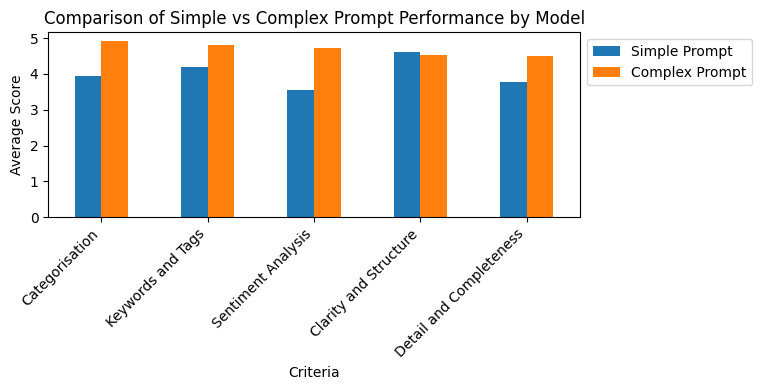

In [11]:
import matplotlib.pyplot as plt

df["simple_scores"] = df["simple_evaluation"].apply(lambda x: [score for key, score in x.model_dump().items() if key != 'justification'])
df["complex_scores"] = df["complex_evaluation"].apply(lambda x: [score for key, score in x.model_dump().items() if key != 'justification'])


# Calculate average scores for each criterion
criteria = [
    'Categorisation',
    'Keywords and Tags',
    'Sentiment Analysis',
    'Clarity and Structure',
    'Detail and Completeness'
]

# Calculate average scores for each criterion by model
simple_avg_scores = df['simple_scores'].apply(pd.Series).mean()
complex_avg_scores = df['complex_scores'].apply(pd.Series).mean()


# Prepare data for plotting
avg_scores_df = pd.DataFrame({
    'Criteria': criteria,
    'Simple Prompt': simple_avg_scores,
    'Complex Prompt': complex_avg_scores
})

# Plotting
ax = avg_scores_df.plot(x='Criteria', kind='bar', figsize=(6, 4))
plt.ylabel('Average Score')
plt.title('Comparison of Simple vs Complex Prompt Performance by Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


After evaluating the results, we found that while the basic prompt performed well in clarity and structure, the enhanced prompt significantly improved outputs across several other key criteria: Categorization, Keywords and Tags, Sentiment Analysis, and Detail and Completeness. The complex prompt led to summaries that were more informative, better organized, and richer in content.

This demonstrates how refining prompts can greatly enhance the quality of the generated summaries. Although this is a simplified example, the benefits of prompt optimization are expected to be even more pronounced in real-world, production-level applications, leading to outputs that are more aligned with specific goals and user needs.

## Conclusion

Meta prompting is a powerful technique that can significantly enhance the quality of outputs from language models. Our exploration showed that starting with a simple prompt and refining it using `o1-preview` led to summaries that were more informative, better organized, and richer in content—improving across key criteria like categorization, keywords and tags, sentiment analysis, and completeness. This exercise underscores the value of prompt optimization, and even in this simplified example, the benefits are clear. In real-world applications, leveraging meta prompting and tools like `o1-preview` can elevate language model performance to better meet your specific goals and user needs.